In [1]:
from __future__ import print_function
import os
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras import losses, metrics
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
img_rows = 256
img_cols = 256
smooth = 1.
holdout_image_dir = '/home/RGD/cleannpy/normalized/holdout/imgs/'

In [3]:
def predict(holdout_image_path):
    
    print('-'*30)
    print('Compiling Model and Loading Weights...')
    print('-'*30)
    
    model = get_unet()
    model.load_weights('/home/RGD/3Scan_Image_Segmentation/Prediction-and-VIsualisation/fullmodel_2.h5')
    
    print('-'*30)
    print('Processing Holdout Image...')
    print('-'*30)
    
    holdout_img = np.load(holdout_image_path)
    expanded_image = holdout_img[:, :, np.newaxis]
    reshape_and_norm_image = reshape_and_normalize_face(expanded_image)
    cropped_256npy_ordered = crop256(reshape_and_norm_image)
    
    print('-'*30)
    print('Predicting and Saving as PNG...')
    print('-'*30)
    
    predictedfullsizelist = []

    for i in cropped_256npy_ordered:
        batch_images = np.zeros((1, img_rows,img_cols,3))
        batch_images[0]=i
        predicted = model.predict(batch_images,verbose=1)
        predictedfullsizelist.append(predicted[0])
        
    fullsized_predicted_image = reconstruct(predictedfullsizelist)
    file_name = 'Predicted_'+str(holdout_image_path)[:-4]+'.png'
    
    plt.imsave(file_name, fullsized_predicted_image, cmap=plt.cm.gray)
    
    print('-'*30)
    print(file_name+' Saved...')
    print('-'*30)
    
    return fullsized_predicted_image
    
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacc_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def get_unet():
    inputs = Input((img_rows, img_cols,3))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    
    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    dropout1 = Dropout(0.5)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(dropout1)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)    
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization(axis = 1)(conv9)
    dropout2 = Dropout(0.5)(conv9)
    
    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(dropout2)
    
    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), 
                  loss=dice_coef_loss, metrics=[dice_coef,jacc_coef_int])

    return model

def reshape_and_normalize_face(face):
    
    shape0 = face.shape[0]//256 * 256
    shape1 = face.shape[1]//256 * 256
    
    # get both to a shape divisible by 32
    face = face[:shape0, :shape1, :]

    
    # rescale all numbers between 0 and 1

    face = face.astype('float32')
    for i in range(face.shape[2]):
        face[:, :, i] = (face[:, :, i] - face[:, :, i].min())/ \
                                    (face[:, :, i].max() - face[:, :, i].min())

    return face

def crop256(stacked):
    
    size_crop = 256
    i = 0
    j = 0
    
    imgs = []

    for i in range(0, stacked.shape[0], size_crop):
        for j in range(0, stacked.shape[1], size_crop):
            image = stacked[i:i+size_crop, j:j+size_crop, :]
            imgs.append(image)
    
    return imgs

def reconstruct(mask_list):
            
    rows = []
    for i in range(0, len(mask_list), 32):
        rows.append(np.concatenate(mask_list[i:i+32], axis = 1))

    reconstructed = np.concatenate(rows, axis = 0)
    
    return reconstructed

In [ ]:
predict(holdout_image_dir)

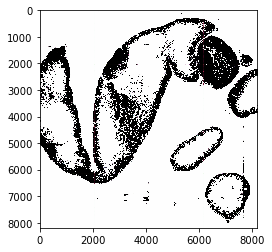

In [102]:
plt.imshow(fullsized_predicted_image)
plt.show()